Data Cleaning

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Set file path and import pandas
file_path = '/content/drive/MyDrive/Colab Notebooks/Zenkart_Dataset.csv'
import pandas as pd


In [51]:
# Load the Zenkart dataset into a DataFrame
df = pd.read_csv(file_path)
df


,OrderID,CustomerID,ProductID,OrderDate,Price,Discount,Quantity,DeliveryTime,Returned,Age,...,TotalOrders,CLV,Churn,Category,MRP,Cost,Rating,Week,Month,DayOfWeek
0,1,68,P10,2024-01-01 00:00:00,1296,0,3,6.3,1,25.0,...,2,13390.37,0,Earphones,856,957,3.3,1,1,0
1,2,253,P9,2024-01-01 08:00:00,1128,20,1,1.6,0,20.0,...,4,4414.19,1,LaptopAccessory,2448,630,4.0,1,1,0
2,3,410,P13,2024-01-01 16:00:00,2151,5,3,5.2,0,20.0,...,2,13177.54,0,LaptopAccessory,2420,1277,NaN,1,1,0
3,4,459,P19,2024-01-02 00:00:00,2173,20,1,1.0,0,20.0,...,4,6646.24,0,Earphones,3709,1603,3.7,1,1,1
4,5,2,P21,2024-01-02 08:00:00,1754,20,2,5.3,0,46.0,...,1,9201.86,0,Earphones,1727,1254,3.7,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,947,17,P14,2024-11-11 08:00:00,549,15,2,5.1,0,19.0,...,2,7976.69,0,Cable,3385,253,3.6,46,11,0
947,948,52,P1,2024-11-11 16:00:00,1767,10,2,1.6,0,53.0,...,2,8551.10,1,Cable,994,364,NaN,46,11,0
948,949,134,P7,2024-11-12 00:00:00,1329,15,2,8.0,1,21.0,...,2,8133.28,0,LaptopAccessory,1877,1096,5.0,46,11,1
949,950,211,P8,2024-11-12 08:00:00,3159,20,1,3.1,0,23.0,...,7,9811.88,0,Cable,795,346,4.5,46,11,1


 handle missing values in Income, DeliveryTime, Rating

In [52]:
# Check missing values in Income, DeliveryTime and Rating
print('Missing values before handling:')
print(df[['Income', 'DeliveryTime', 'Rating']].isnull().sum())
df.shape


Missing values before handling:
Income           48
DeliveryTime     38
Rating          210
dtype: int64


(951, 22)

In [53]:
# Impute missing Income and DeliveryTime using median values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df[['Income']] = imputer.fit_transform(df[['Income']])
df[['DeliveryTime']] = imputer.fit_transform(df[['DeliveryTime']])


In [54]:
# Create HasRated flag and compute baseline time series error on raw data
df['HasRated'] = df['Rating'].notnull().astype(int)


Identify and fix outliers in Price, CLV, and DeliveryTime data types

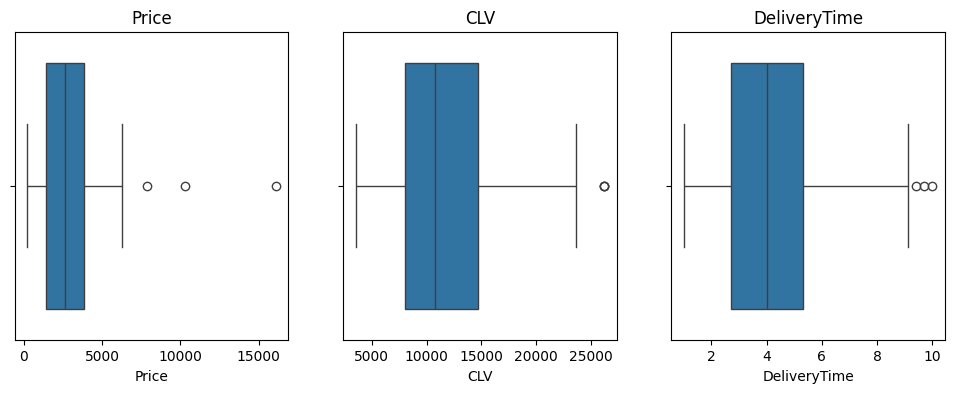

In [55]:
# Visualize and cap outliers, and evaluate model on cleaned time series
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

columns = ['Price', 'CLV', 'DeliveryTime']

for index, column in enumerate(columns):
    sns.boxplot(x=df[column], ax=ax[index])
    ax[index].set_title(column)

plt.show()



In [56]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
upper = int(upper)

df.loc[df['Price'] > upper, 'Price'] = upper
df.loc[df['Price'] < 0, 'Price'] = 0



In [57]:
Q1 = df['CLV'].quantile(0.25)
Q3 = df['CLV'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

upper = int(upper)

df.loc[df['CLV'] > upper, 'CLV'] = upper
df.loc[df['CLV'] < 0, 'CLV'] = 0

In [58]:
Q1 = df['DeliveryTime'].quantile(0.25)
Q3 = df['DeliveryTime'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df.loc[df['DeliveryTime'] > upper, 'DeliveryTime'] = upper
df.loc[df['DeliveryTime'] < lower, 'DeliveryTime'] = lower


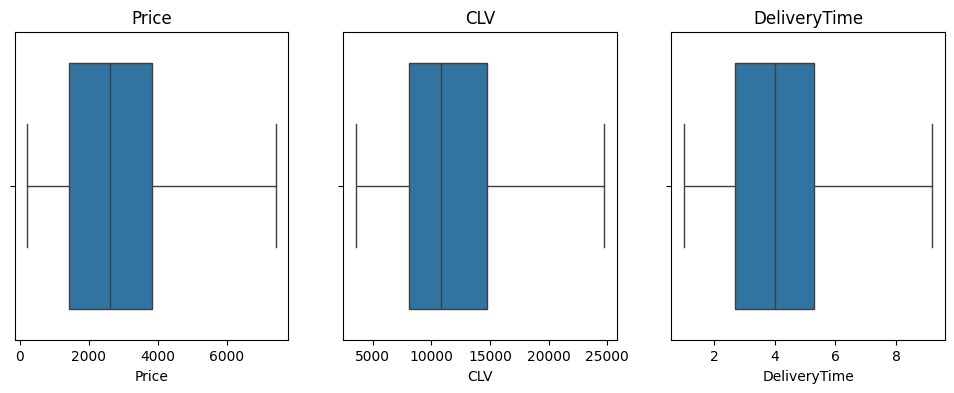

In [59]:

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

columns = ['Price', 'CLV', 'DeliveryTime']

for index, column in enumerate(columns):
    sns.boxplot(x=df[column], ax=ax[index])
    ax[index].set_title(column)

plt.show()

# Clustering:

Group customers into meaningful segments based on demographics and purchasing
behaviour to help Zenkart understand customer behaviour.

In [60]:
# Verify that customers have multiple transactions per CustomerID
(df['CustomerID'].value_counts() > 1).sum()


np.int64(283)

In [61]:
# Aggregate transactions to customer-level features for clustering
customer_df = df.groupby('CustomerID').agg({
    'OrderDate': 'max',        # To calculate Recency
    'OrderID': 'count',        # Frequency
    'Price': 'sum',            # Monetary
    'DeliveryTime': 'mean',    # Average delivery experience
    'CLV': 'max',              # Lifetime value
    'Age': 'mean',             # Demographics
    'Income': 'mean',          # Demographics
    'CityTier': 'mean'         # Demographics
}).rename(columns={
    'OrderID': 'Frequency',
    'Price': 'Monetary',
    'DeliveryTime': 'AvgDeliveryTime'
})


In [62]:
# Convert dates and compute Recency (days since last purchase)
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
max_date = df['OrderDate'].max()
customer_df['OrderDate'] = pd.to_datetime(customer_df['OrderDate'])
customer_df['Recency'] = (max_date - customer_df['OrderDate']).dt.days
customer_df.drop(columns=['OrderDate'], inplace=True)


In [63]:
customer_df.head()


,Frequency,Monetary,AvgDeliveryTime,CLV,Age,Income,CityTier,Recency
CustomerID,,,,,,,,
1,2,5576,3.150000,10718.59,56.0,48896.52,3.0,23
2,2,3376,3.150000,9201.86,46.0,35356.80,2.0,264
3,1,2136,5.700000,12755.04,32.0,44892.00,3.0,7
4,4,6162,4.125000,7292.60,25.0,21233.30,3.0,2
5,3,4428,3.533333,17812.71,38.0,53860.41,1.0,87


In [64]:
# Quick check of the aggregated customer-level dataset
customer_df['Age'] = customer_df['Age'].fillna(customer_df['Age'].median())


In [65]:
# Import scaler to standardize features before K-Means
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(customer_df)


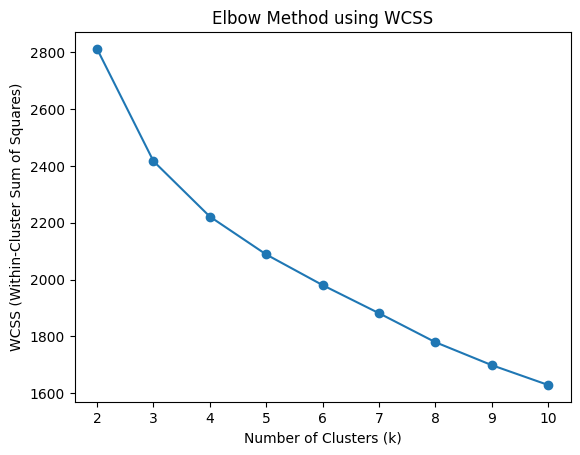

In [96]:
# Import K-Means algorithm for customer segmentation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        random_state=0,
        max_iter=300
    )
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method using WCSS')
plt.show()


In [67]:
# Fit final K-Means model with 4 customer clusters
kmeans = KMeans(
    n_clusters=4,
    init='k-means++',
    random_state=0,
    max_iter=300
)

customer_df['Cluster'] = kmeans.fit_predict(X_scaled)


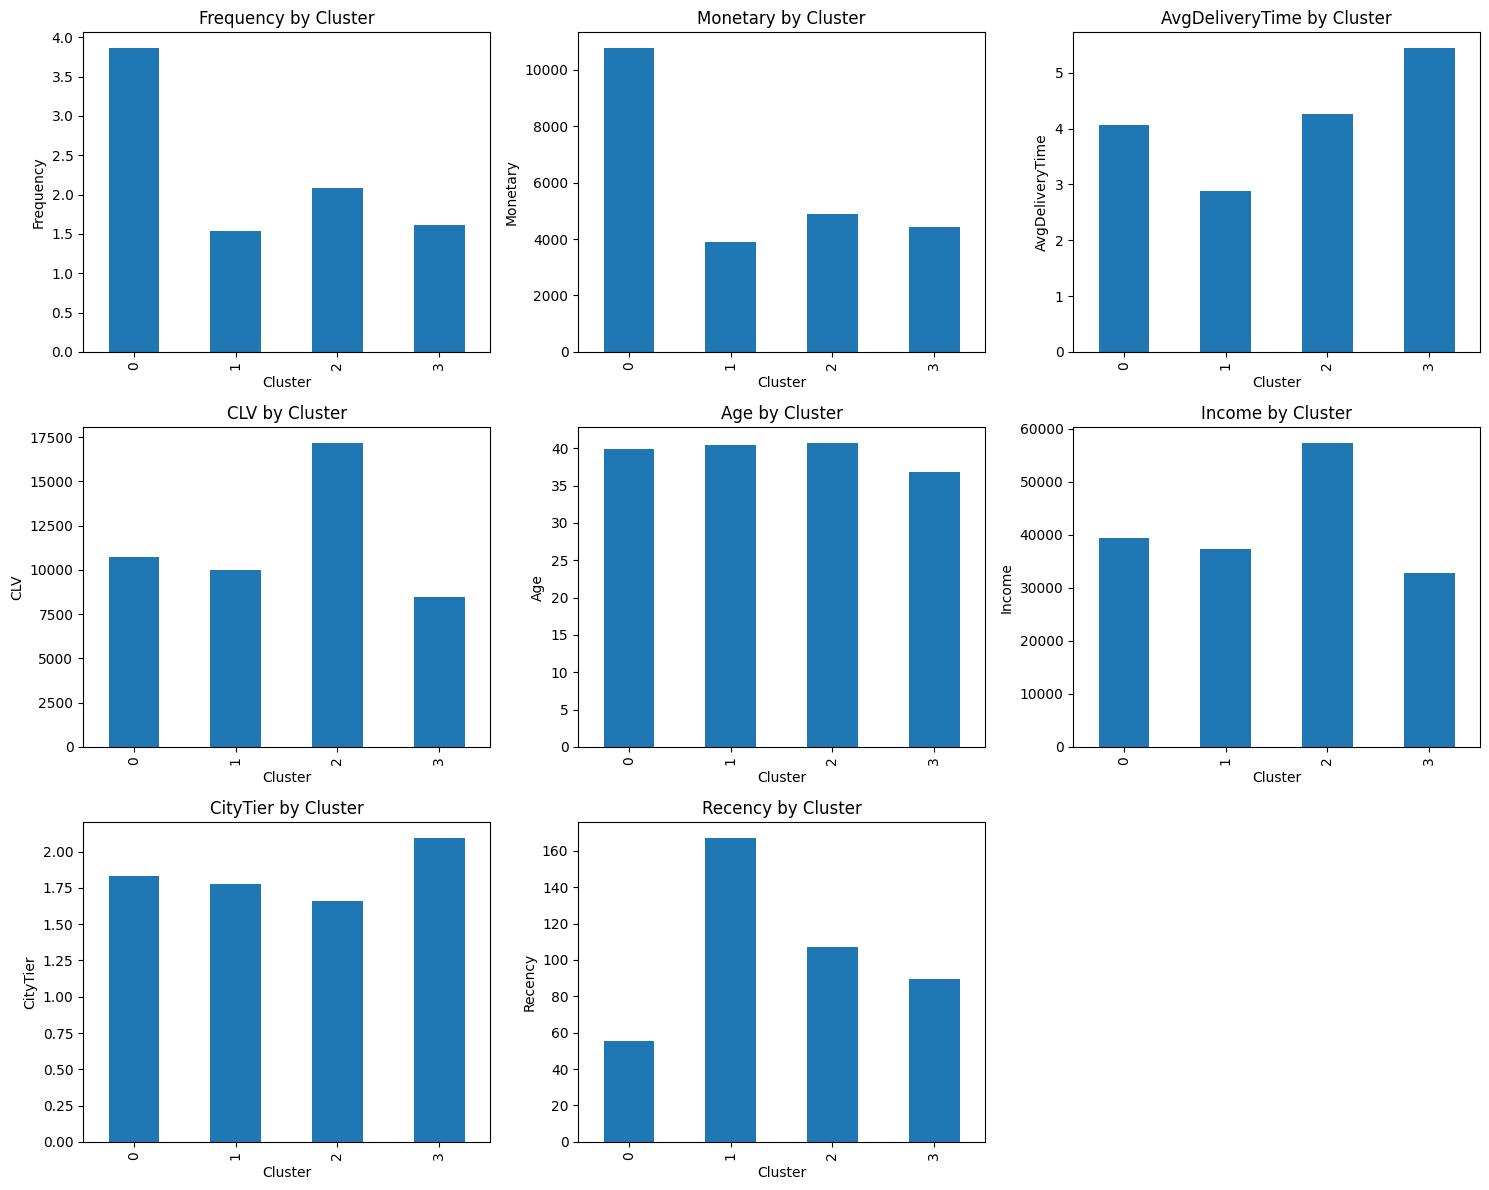

In [68]:
# Compare cluster profiles across key features using bar charts
features = ['Frequency', 'Monetary', 'AvgDeliveryTime', 'CLV',
            'Age', 'Income', 'CityTier', 'Recency']

cluster_summary = customer_df.groupby('Cluster')[features].mean()

plt.figure(figsize=(15, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    cluster_summary[col].plot(kind='bar')
    plt.title(f'{col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


 Classification:
Predict whether a customer is likely to churn (1) or stay active (0).


In [69]:
# Build customer-level dataset for churn modelling
churn_df = df.groupby('CustomerID').agg({
    'OrderDate': 'max',        # for recency
    'OrderID': 'count',        # frequency
    'Price': 'sum',            # monetary
    'DeliveryTime': 'mean',    # avg delivery time
    'CLV': 'max',              # lifetime value
    'Age': 'mean',             # age
    'Income': 'mean',          # income
    'CityTier': 'mean'         # city tier
}).rename(columns={
    'OrderID': 'Frequency',
    'Price': 'Monetary',
    'DeliveryTime': 'AvgDeliveryTime'
})

# make sure OrderDate is datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
max_date = df['OrderDate'].max()

churn_df['OrderDate'] = pd.to_datetime(churn_df['OrderDate'])
churn_df['Recency'] = (max_date - churn_df['OrderDate']).dt.days
churn_df.drop(columns=['OrderDate'], inplace=True)



In [70]:

# Attach churn label per customer and prepare train-test split
churn_label = df.groupby('CustomerID')['Churn'].max()

churn_df['Churn'] = churn_label


In [71]:
# Impute missing Age values in churn dataset using median
churn_df['Age'] = churn_df['Age'].fillna(churn_df['Age'].median())



In [72]:
# Select features and target variable for churn prediction
feature_cols = ['Recency', 'Frequency', 'Monetary',
                'AvgDeliveryTime', 'CLV',
                'Age', 'Income', 'CityTier']

X = churn_df[feature_cols]
y = churn_df['Churn']


In [73]:
# Import train-test split utility for model evaluation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=0,
    stratify=y
)


In [74]:
# Standardize churn features so no single variable dominates
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [99]:
# Train Logistic Regression model to predict churn
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

In [100]:
# Evaluate churn model performance on the test set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.813953488372093
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.89        69
           1       0.67      0.12      0.20        17

    accuracy                           0.81        86
   macro avg       0.74      0.55      0.55        86
weighted avg       0.79      0.81      0.76        86

Confusion Matrix:
 [[68  1]
 [15  2]]


Logistic Regression with class_weight='balanced


In [77]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6046511627906976
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.57      0.70        69
           1       0.30      0.76      0.43        17

    accuracy                           0.60        86
   macro avg       0.60      0.66      0.56        86
weighted avg       0.79      0.60      0.64        86

Confusion Matrix:
 [[39 30]
 [ 4 13]]


Time Series Analysis:
Forecast sales for the next 10–12 weeks. Assess how missing data and outliers impact the
forecasting model's accuracy.


In [78]:
# Prepare data and libraries for time series forecasting
import pandas as pd
import matplotlib.pyplot as plt

df['OrderDate'] = pd.to_datetime(df['OrderDate'])


In [79]:
# Set OrderDate as index and sort
ts_df = df.set_index('OrderDate').sort_index()

# Weekly sales = sum of Price per week
weekly_sales = ts_df['Price'].resample('W').sum()

print(weekly_sales.head())


OrderDate
2024-01-07    49505
2024-01-14    68859
2024-01-21    52960
2024-01-28    58670
2024-02-04    63246
Freq: W-SUN, Name: Price, dtype: int64


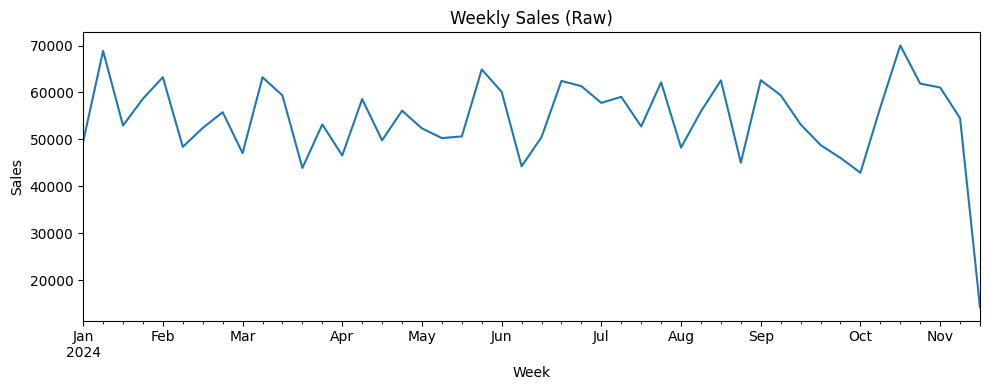

In [80]:
# Plot raw weekly sales to inspect trend and variability
plt.figure(figsize=(10, 4))
weekly_sales.plot()
plt.title('Weekly Sales (Raw)')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


In [81]:
# Split weekly series into training and last 12 weeks as test set
test_weeks = 12

train_raw = weekly_sales.iloc[:-test_weeks]
test_raw = weekly_sales.iloc[-test_weeks:]

print("Train length:", len(train_raw))
print("Test length:", len(test_raw))


Train length: 34
Test length: 12


In [82]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit model on raw (uncleaned) data
model_raw = SimpleExpSmoothing(train_raw).fit()

# Forecast for test period
forecast_raw = model_raw.forecast(len(test_raw))


In [83]:
import numpy as np

mape_raw = np.mean(np.abs((test_raw - forecast_raw) / test_raw)) * 100
print("MAPE (raw data):", mape_raw)


MAPE (raw data): 34.71350274236979


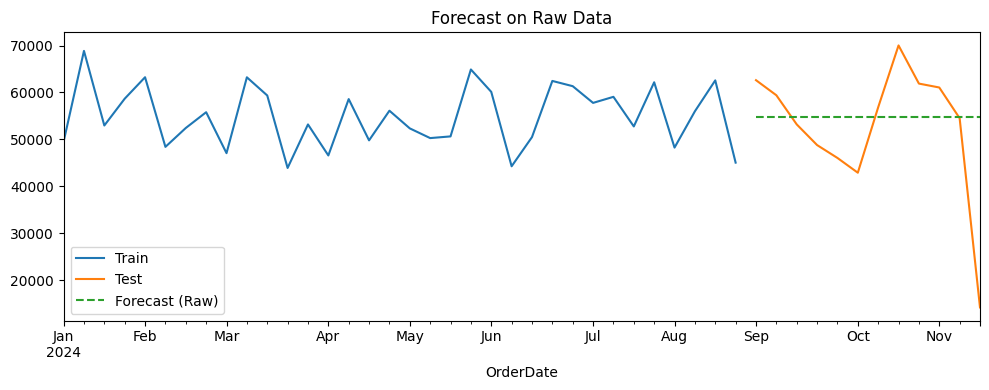

In [84]:
plt.figure(figsize=(10,4))
train_raw.plot(label='Train')
test_raw.plot(label='Test')
forecast_raw.plot(label='Forecast (Raw)', linestyle='--')
plt.legend()
plt.title('Forecast on Raw Data')
plt.tight_layout()
plt.show()


In [85]:
weekly_clean = weekly_sales.asfreq('W')  # explicitly weekly index

# Fill missing weeks by carrying last value forward (or you can use .fillna(0))
weekly_clean = weekly_clean.fillna(method='ffill')


/tmp/ipython-input-1257765601.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_clean = weekly_clean.fillna(method='ffill')


In [86]:
Q1 = weekly_clean.quantile(0.25)
Q3 = weekly_clean.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Cap extremes
weekly_clean = weekly_clean.clip(lower=lower, upper=upper)


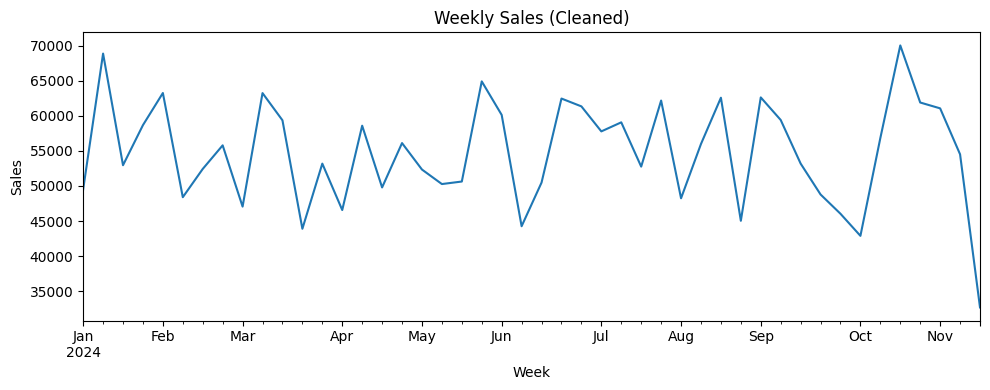

In [87]:
plt.figure(figsize=(10, 4))
weekly_clean.plot()
plt.title('Weekly Sales (Cleaned)')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


In [88]:
train_clean = weekly_clean.iloc[:-test_weeks]
test_clean = weekly_clean.iloc[-test_weeks:]


In [89]:
# Fit model on cleaned data
model_clean = SimpleExpSmoothing(train_clean).fit()

# Forecast for test period
forecast_clean = model_clean.forecast(len(test_clean))

# MAPE for cleaned data
mape_clean = np.mean(np.abs((test_clean - forecast_clean) / test_clean)) * 100
print("MAPE (cleaned data):", mape_clean)


MAPE (cleaned data): 16.475583973611077


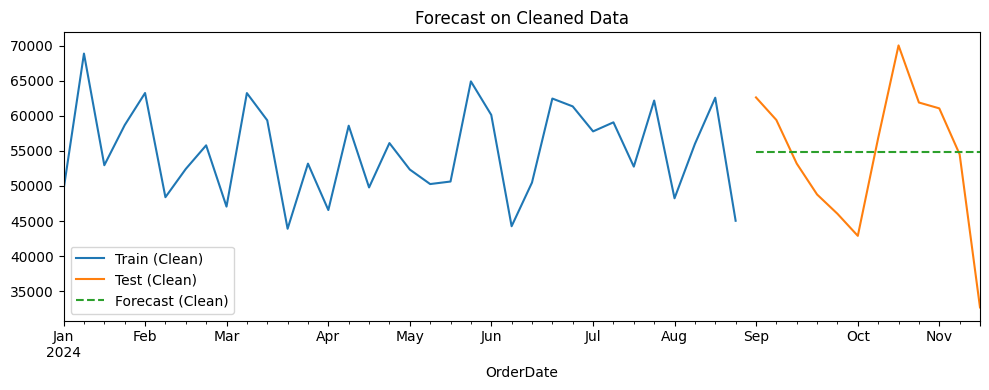

In [90]:
plt.figure(figsize=(10,4))
train_clean.plot(label='Train (Clean)')
test_clean.plot(label='Test (Clean)')
forecast_clean.plot(label='Forecast (Clean)', linestyle='--')
plt.legend()
plt.title('Forecast on Cleaned Data')
plt.tight_layout()
plt.show()
